# Pure vapour-liquid equilibrium properties

In [1]:
import Pkg
Pkg.status("Clapeyron")

Project Clapeyron v0.6.13
No Matches in `/mnt/c/Users/darshanraju/OneDrive - Delft University of Technology/Desktop/Clapeyron/Clapeyron.jl/Project.toml`


In [2]:
using Clapeyron, PyCall
using CSV, DataFrames
import PyPlot; const plt = PyPlot

PyPlot

In this notebook, we give additional examples of pure component vapour-liquid equilibrium properties users can obtain in `Clapeyron.jl`. Many examples have been given in other notebooks; as such, we focus on those functionalities not illustrated elsewhere.

## Saturation curve of water

A simple example to start with, let us obtain the saturation curve of water.

First generating the model:

In [3]:
model1 = GERG2008(["carbon dioxide"])
model2 = PCSAFT(["carbon dioxide"])
model3 = EOS_CG(["carbon dioxide"])
model4 = PR(["carbon dioxide"])

models = Dict(
    "GERG2008" => model1,
    "PCSAFT" => model2,
    "EOS_CG" => model3,
    "PR" => model4
)

model_data = Dict{String, Dict{String, Any}}()

for (name, model) in models
    Mw = model.params.Mw[1]
    Tc, pc, vc = crit_pure(model)
    model_data[name] = Dict(
        "Mw" => Mw,
        "Tc" => Tc,
        "pc" => pc,
        "vc" => vc
    )
end

println("Critical temperature of PCSAFT: ", model_data["PCSAFT"]["Tc"])
println("Molecular weight of EOS_CG: ", model_data["EOS_CG"]["Mw"])
println("Crtical temperature of GERG2008: ", model_data["GERG2008"]["Tc"])

Critical temperature of PCSAFT: 310.27679925044134
Molecular weight of EOS_CG: 44.0098
Crtical temperature of GERG2008: 304.1282


We then need to obtain the critical point (since that will be the end-point of our curve):

From here, choosing an arbitrary low temperature, we can trace the saturation curve up to the critical point. To avoid numerical issues, we will use the solution of the previous iteration as the initial guess for the next iteration:

In [4]:
# Saturation pressure calculation

N    = 100

Tc   = model_data["GERG2008"]["Tc"]

T    = LinRange(220, Tc,  N)
psat = zeros(N)
vl   = zeros(N)
vv   = zeros(N)

v0   = nothing 

hL   = zeros(N)
hV   = zeros(N)
cpL  = zeros(N)
cpV  = zeros(N)

for i in 1:N
    if i==1
        sat = saturation_pressure(model1, T[i])
        psat[i] = sat[1]
        vl[i] = sat[2]
        vv[i] = sat[3]
        v0 = [vl[i],vv[i]]
        # println("Saturation at T = ", T[i], " K: psat = ", psat[i], ", vl = ", vl[i], ", vv = ", vv[i])
    else
        sat = saturation_pressure(model1, T[i]; v0=v0)
        psat[i] = sat[1]
        vl[i] = sat[2]
        vv[i] = sat[3]
        v0 = [vl[i],vv[i]]
    end

end

In [12]:
for (name, model) in models
    Tc = model_data[name]["Tc"]
    Tsc = LinRange(Tc, 350.0, N)

    pw = zeros(N)
    vw = zeros(N)

    for i in 1:N
        sc = widom_pressure(model, Tsc[i])
        pw[i] = sc[1]
        vw[i] = sc[2]
    end

    model_data[name]["Tsc"] = Tsc
    model_data[name]["pw"]  = pw
    model_data[name]["vw"]  = vw
end

println("First Widom pressure from PR: ", model_data["PR"]["pw"][2])

First Widom pressure from PR: 7.466093833573863e6


Plotting:

In [18]:
for (name, model) in models
    filename = "$(name)_Widom.csv"

    open(filename, "w") do io
        println(io, "Tsc,pw,vw")

        Tsc = model_data[name]["Tsc"]
        pw  = model_data[name]["pw"]
        vw  = model_data[name]["vw"]

        for i in 1:length(Tsc)
            println(io, "$(Tsc[i]),$(pw[i]),$(vw[i])")
        end
    end
end

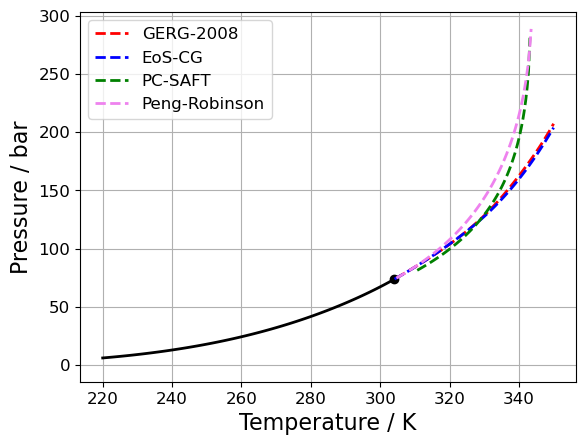

In [41]:
plt.clf()
plt.plot(T, psat./1e5, color="k",linewidth=2)
plt.plot(model_data["GERG2008"]["Tc"],model_data["GERG2008"]["pc"]./1e5, marker="o",color="k", linewidth=2,linestyle="--")
plt.plot(model_data["GERG2008"]["Tsc"], model_data["GERG2008"]["pw"]./1e5, color="red", label="GERG-2008", linewidth=2,linestyle="--")
plt.plot(model_data["EOS_CG"]["Tsc"], model_data["EOS_CG"]["pw"]./1e5, color="blue", label="EoS-CG",linewidth=2,linestyle="--")
plt.plot(model_data["PCSAFT"]["Tsc"], model_data["PCSAFT"]["pw"]./1e5, color="green", label="PC-SAFT",linewidth=2,linestyle="--")
plt.plot(model_data["PR"]["Tsc"], model_data["PR"]["pw"]./1e5, color="violet", label="Peng-Robinson",linewidth=2,linestyle="--")

plt.xlabel("Temperature / K",fontsize=16)
plt.ylabel("Pressure / bar",fontsize=16)
# plt.xlim([300,690])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid()
display(plt.gcf())